# Project Deliverable 3: Classification, Clustering, and Pattern Mining
**Student Name:** Gaurab Karki  
**Course:** 2025 Fall - Advanced Big Data and Data Mining (MSCS-634-B01)

Dataset: Synthetic Healthcare Dataset (`healthcare_dataset.csv`)

In this notebook, I will:
- Build and evaluate **classification models** to predict whether a patient has Diabetes
- Perform **hyperparameter tuning** for k-NN.
- Compute **confusion matrix, ROC curve, Accuracy, and F1 score**.
- Build a **K-Means clustering** model and interpret clusters.
- Apply **association rule mining (Apriori)** to find interesting patterns.
- Provide **real-world insights** based on the discovered patterns.

Imports

In [62]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: preprocessing, models, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
    roc_curve,
    auc
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Association rule mining
# If not installed: pip install mlxtend
from mlxtend.frequent_patterns import apriori, association_rules

# Display options
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

Load Data & Initial Inspection

In [63]:
# Load the healthcare dataset
df = pd.read_csv("healthcare_dataset.csv")

df.head()

# Basic information and summary
df.info()

df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 6.4

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
count,55500,55500.000000,55500,55500,55500,55500,55500,55500,55500,55500.000000,55500.000000,55500,55500,55500,55500
unique,49992,NaN,2,8,6,1827,40341,39876,5,NaN,NaN,3,1856,5,3
top,DAvId muNoZ,NaN,Male,A-,Arthritis,2024-03-16,Michael Smith,LLC Smith,Cigna,NaN,NaN,Elective,2020-03-15,Lipitor,Abnormal
freq,3,NaN,27774,6969,9308,50,27,44,11249,NaN,NaN,18655,53,11140,18627
mean,NaN,51.539459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25539.316097,301.134829,NaN,NaN,NaN,NaN
std,NaN,19.602454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14211.454431,115.243069,NaN,NaN,NaN,NaN
min,NaN,13.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2008.492140,101.000000,NaN,NaN,NaN,NaN
25%,NaN,35.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13241.224652,202.000000,NaN,NaN,NaN,NaN
50%,NaN,52.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25538.069376,302.000000,NaN,NaN,NaN,NaN
75%,NaN,68.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37820.508436,401.000000,NaN,NaN,NaN,NaN


Data Cleaning & Feature Engineering

Here, I will:
- Parse dates.
- Create Length_of_Stay.
- Clean text columns.
- Create a binary target: Diabetes vs non-Diabetes.

In [64]:
# Convert dates
df["Date of Admission"] = pd.to_datetime(df["Date of Admission"])
df["Discharge Date"] = pd.to_datetime(df["Discharge Date"])

# Length of stay in days
df["Length_of_Stay"] = (df["Discharge Date"] - df["Date of Admission"]).dt.days

# Clean up some text columns (title case)
for col in ["Name", "Doctor", "Hospital", "Medical Condition", 
            "Insurance Provider", "Admission Type", "Medication", "Test Results"]:
    df[col] = df[col].astype(str).str.strip().str.title()

df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,Length_of_Stay
0,Bobby Jackson,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons And Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal,2
1,Leslie Terry,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive,6
2,Danny Smith,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook Plc,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal,15
3,Andrew Watts,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers And Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal,30
4,Adrienne Bell,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal,20


### Defining Target and Features for Classification

Target: Diabetes vs non-Diabetes

In [65]:
# Binary classification target: Diabetes = 1, non-Diabetes = 0
df["is_Diabetes"] = (df["Medical Condition"].str.lower() == "diabetes").astype(int)

# Features for classification (drop identifiers and target/leaky columns)
feature_cols = [
    "Age",
    "Gender",
    "Blood Type",
    "Admission Type",
    "Billing Amount",
    "Length_of_Stay",
    "Insurance Provider",
    "Medication",
    "Test Results"
]

X = df[feature_cols].copy()
y = df["is_Diabetes"]

X.head(), y.value_counts()

(   Age  Gender Blood Type Admission Type  Billing Amount  Length_of_Stay  \
 0   30    Male         B-         Urgent    18856.281306               2   
 1   62    Male         A+      Emergency    33643.327287               6   
 2   76  Female         A-      Emergency    27955.096079              15   
 3   28  Female         O+       Elective    37909.782410              30   
 4   43  Female        AB+         Urgent    14238.317814              20   
 
   Insurance Provider   Medication  Test Results  
 0         Blue Cross  Paracetamol        Normal  
 1           Medicare    Ibuprofen  Inconclusive  
 2              Aetna      Aspirin        Normal  
 3           Medicare    Ibuprofen      Abnormal  
 4              Aetna   Penicillin      Abnormal  ,
 is_Diabetes
 0    46196
 1     9304
 Name: count, dtype: int64)

Train-Test Split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(is_Diabetes
 0    0.832365
 1    0.167635
 Name: proportion, dtype: float64,
 is_Diabetes
 0    0.832342
 1    0.167658
 Name: proportion, dtype: float64)

Preprocessing Pipeline

In [67]:
numeric_features = ["Age", "Billing Amount", "Length_of_Stay"]
categorical_features = [
    "Gender", "Blood Type", "Admission Type",
    "Insurance Provider", "Medication", "Test Results"
]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

## Classification Model 1: Decision Tree

This step implements the first required classification model: Decision Tree classifier. The goal is to establish a baseline predictive model for identifying diabetes cases.

In [43]:
# Pipeline: preprocessing + Decision Tree
dt_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", DecisionTreeClassifier(
        random_state=42,
        max_depth=None  # default (no limit)
    ))
])

dt_clf.fit(X_train, y_train)

y_pred_dt = dt_clf.predict(X_test)
y_proba_dt = dt_clf.predict_proba(X_test)[:, 1]  # probability of class 1 (Diabetes)

acc_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

print("Decision Tree Accuracy:", acc_dt)
print("Decision Tree F1 Score:", f1_dt)
print("\nClassification Report (Decision Tree):\n")
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.7379279279279279
Decision Tree F1 Score: 0.26854412874025646

Classification Report (Decision Tree):

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      9239
           1       0.25      0.29      0.27      1861

    accuracy                           0.74     11100
   macro avg       0.55      0.56      0.55     11100
weighted avg       0.75      0.74      0.74     11100



## Classification Model 2: k-NN (Baseline)

This is the second required classification model. The k-NN baseline will later be improved using hyperparameter tuning.


In [44]:
knn_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", KNeighborsClassifier(
        n_neighbors=5,
        weights="uniform"
    ))
])

knn_clf.fit(X_train, y_train)

y_pred_knn = knn_clf.predict(X_test)
y_proba_knn = knn_clf.predict_proba(X_test)[:, 1]

acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

print("k-NN (baseline) Accuracy:", acc_knn)
print("k-NN (baseline) F1 Score:", f1_knn)
print("\nClassification Report (k-NN baseline):\n")
print(classification_report(y_test, y_pred_knn))

k-NN (baseline) Accuracy: 0.8077477477477477
k-NN (baseline) F1 Score: 0.10486577181208054

Classification Report (k-NN baseline):

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      9239
           1       0.24      0.07      0.10      1861

    accuracy                           0.81     11100
   macro avg       0.54      0.51      0.50     11100
weighted avg       0.74      0.81      0.76     11100



Hyperparameter Tuning for k-NN (Grid Search)

## Hyperparameter Tuning for k-NN

I chose to tune the following hyperparameters for the k-NN classifier:

- `n_neighbors`: number of neighbors used for classification (controls model complexity).
- `weights`: `"uniform"` vs `"distance"` weighting of neighbors.
- `metric`: distance function (`"euclidean"` vs `"manhattan"`).

I used **GridSearchCV** with 5-fold cross-validation and `f1` as the scoring metric
to balance precision and recall on the (possibly) imbalanced diabetes vs non-diabetes classes.

In [45]:
param_grid = {
    "clf__n_neighbors": [3, 5, 7, 9, 11],
    "clf__weights": ["uniform", "distance"],
    "clf__metric": ["euclidean", "manhattan"]
}

knn_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", KNeighborsClassifier())
])

grid_search = GridSearchCV(
    estimator=knn_pipe,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV F1 score:", grid_search.best_score_)

Best parameters: {'clf__metric': 'manhattan', 'clf__n_neighbors': 3, 'clf__weights': 'distance'}
Best CV F1 score: 0.2539258803944825


Evaluate Tuned k-NN

In [46]:
best_knn = grid_search.best_estimator_

y_pred_best_knn = best_knn.predict(X_test)
y_proba_best_knn = best_knn.predict_proba(X_test)[:, 1]

acc_best_knn = accuracy_score(y_test, y_pred_best_knn)
f1_best_knn = f1_score(y_test, y_pred_best_knn)

print("Tuned k-NN Accuracy:", acc_best_knn)
print("Tuned k-NN F1 Score:", f1_best_knn)
print("\nClassification Report (Tuned k-NN):\n")
print(classification_report(y_test, y_pred_best_knn))

Tuned k-NN Accuracy: 0.7932432432432432
Tuned k-NN F1 Score: 0.2753394379538996

Classification Report (Tuned k-NN):

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      9239
           1       0.33      0.23      0.28      1861

    accuracy                           0.79     11100
   macro avg       0.59      0.57      0.58     11100
weighted avg       0.77      0.79      0.78     11100



## Confusion Matrices

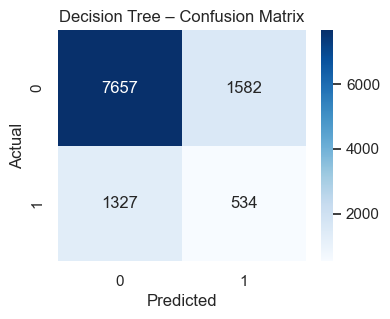

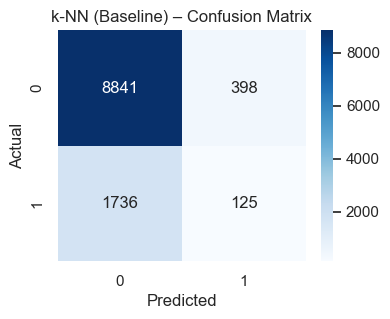

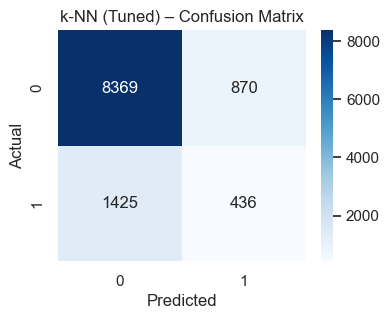

In [47]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(y_test, y_pred_dt, "Decision Tree – Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_knn, "k-NN (Baseline) – Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_best_knn, "k-NN (Tuned) – Confusion Matrix")

### ROC Curves (Binary Classification)

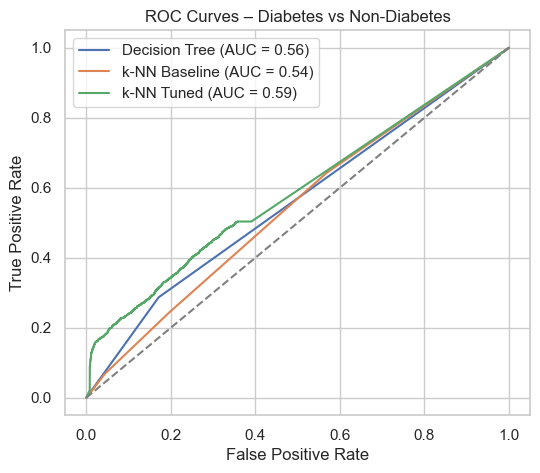

In [48]:
# ROC for each model
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_knn_base, tpr_knn_base, _ = roc_curve(y_test, y_proba_knn)
roc_auc_knn_base = auc(fpr_knn_base, tpr_knn_base)

fpr_knn_best, tpr_knn_best, _ = roc_curve(y_test, y_proba_best_knn)
roc_auc_knn_best = auc(fpr_knn_best, tpr_knn_best)

plt.figure(figsize=(6, 5))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.2f})")
plt.plot(fpr_knn_base, tpr_knn_base, label=f"k-NN Baseline (AUC = {roc_auc_knn_base:.2f})")
plt.plot(fpr_knn_best, tpr_knn_best, label=f"k-NN Tuned (AUC = {roc_auc_knn_best:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Diabetes vs Non-Diabetes")
plt.legend()
plt.show()

### Compare Accuracy & F1 Scores

In [49]:
results = pd.DataFrame({
    "Model": ["Decision Tree", "k-NN Baseline", "k-NN Tuned"],
    "Accuracy": [acc_dt, acc_knn, acc_best_knn],
    "F1": [f1_dt, f1_knn, f1_best_knn]
})

results


,Model,Accuracy,F1
0,Decision Tree,0.737928,0.268544
1,k-NN Baseline,0.807748,0.104866
2,k-NN Tuned,0.793243,0.275339


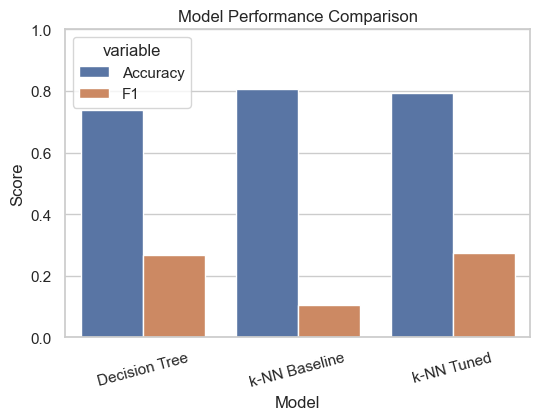

In [50]:
plt.figure(figsize=(6, 4))
sns.barplot(data=results.melt(id_vars="Model", value_vars=["Accuracy", "F1"]),
            x="Model", y="value", hue="variable")
plt.ylim(0, 1)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.show()

## Clustering with K-Means

In [51]:
# Use the same preprocessor to transform full X (without target)
X_full = X.copy()

X_preprocessed = preprocessor.fit_transform(X_full)

X_preprocessed.shape

(55500, 29)

Elbow Method

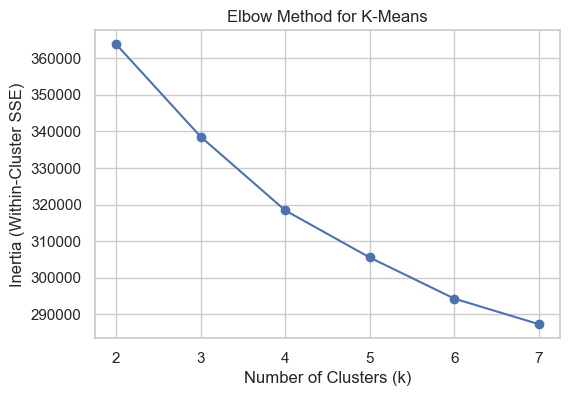

In [52]:
inertias = []
k_values = range(2, 8)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_preprocessed)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(k_values, inertias, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.title("Elbow Method for K-Means")
plt.show()

Suppose we choose k = 3,  k where the elbow appears

In [53]:
k_opt = 3  # adjust if the elbow suggests another value

kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_preprocessed)

df["Cluster_KMeans"] = cluster_labels
df["Cluster_KMeans"].value_counts()

Cluster_KMeans
0    20560
1    17673
2    17267
Name: count, dtype: int64

## Visualizing Clusters using PCA (2D)

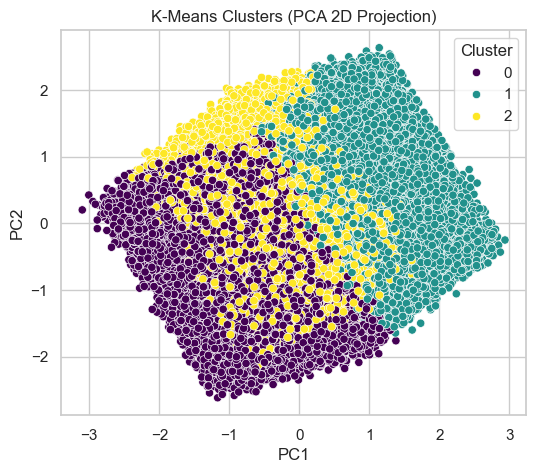

In [54]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_preprocessed)

plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=cluster_labels,
    palette="viridis"
)
plt.title("K-Means Clusters (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

Interpret Cluster Characteristics

In [55]:
cluster_profile = df.groupby("Cluster_KMeans")[[
    "Age", "Billing Amount", "Length_of_Stay"
]].mean().round(2)

cluster_profile

,Age,Billing Amount,Length_of_Stay
Cluster_KMeans,,,
0,30.72,25712.09,15.32
1,63.65,25314.14,23.58
2,63.93,25564.07,7.48


In [56]:
pd.crosstab(df["Cluster_KMeans"], df["Medical Condition"])

Medical Condition,Arthritis,Asthma,Cancer,Diabetes,Hypertension,Obesity
Cluster_KMeans,,,,,,
0,3479,3435,3396,3420,3402,3428
1,2952,2967,2958,2914,2934,2948
2,2877,2783,2873,2970,2909,2855


### Cluster Interpretation Based on Medical Condition Distribution

- **Cluster 0:**  
  This cluster has the highest counts across all medical conditions. This suggests that Cluster 0 represents the largest and most condition-diverse group of patients. It may represent the “general” patient population.

- **Cluster 1:**  
  Shows consistently lower counts for each condition compared to Cluster 0. This cluster may represent a smaller or less medically complex patient segment.

- **Cluster 2:**  
  Has medical condition counts similar to Cluster 1, but it shows the **highest Diabetes count** among all clusters.  
  This could indicate that Cluster 2 includes a subgroup with relatively more diabetes cases or patterns tied to diabetic patients.

## Association Rule Mining (Apriori)

We will treat each patient as a “transaction” of categorical attributes: gender, blood type, condition, admission type, medication, test results, insurance provider.

In [57]:
cat_for_rules = df[[
    "Gender",
    "Blood Type",
    "Medical Condition",
    "Admission Type",
    "Medication",
    "Test Results",
    "Insurance Provider"
]].copy()

# One-hot encode to transaction format
transactions = pd.get_dummies(cat_for_rules)

transactions.head()

,Gender_Female,Gender_Male,Blood Type_A+,Blood Type_A-,Blood Type_AB+,Blood Type_AB-,Blood Type_B+,Blood Type_B-,Blood Type_O+,Blood Type_O-,Medical Condition_Arthritis,Medical Condition_Asthma,Medical Condition_Cancer,Medical Condition_Diabetes,Medical Condition_Hypertension,Medical Condition_Obesity,Admission Type_Elective,Admission Type_Emergency,Admission Type_Urgent,Medication_Aspirin,Medication_Ibuprofen,Medication_Lipitor,Medication_Paracetamol,Medication_Penicillin,Test Results_Abnormal,Test Results_Inconclusive,Test Results_Normal,Insurance Provider_Aetna,Insurance Provider_Blue Cross,Insurance Provider_Cigna,Insurance Provider_Medicare,Insurance Provider_Unitedhealthcare
0,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False,False,False
1,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,False,False,False,True,False
2,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,True,True,False,False,False,False
3,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False
4,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,True,False,False,True,False,False,False,False


### Run Apriori to Find Frequent Itemsets

In [58]:
from mlxtend.frequent_patterns import apriori, association_rules

# Adjust min_support: start with 0.01 (1% of records)
frequent_itemsets = apriori(
    transactions,
    min_support=0.01,    # was probably 0.05 before
    use_colnames=True
)

print("Number of frequent itemsets:", frequent_itemsets.shape[0])
frequent_itemsets.sort_values("support", ascending=False).head(10)

Number of frequent itemsets: 2078


,support,itemsets
1,0.500432,(Gender_Male)
0,0.499568,(Gender_Female)
16,0.336126,(Admission Type_Elective)
24,0.335622,(Test Results_Abnormal)
18,0.334703,(Admission Type_Urgent)
26,0.333640,(Test Results_Normal)
25,0.330739,(Test Results_Inconclusive)
17,0.329171,(Admission Type_Emergency)
29,0.202685,(Insurance Provider_Cigna)
30,0.200973,(Insurance Provider_Medicare)


Generate Association Rules

In [59]:
# Generate rules with a modest lift threshold
rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.0      # instead of 1.1 or higher
)

print("Total rules generated:", rules.shape[0])
rules.sort_values("lift", ascending=False).head(10)

Total rules generated: 6062


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
4932,(Admission Type_Elective),"(Gender_Female, Insurance Provider_Aetna, Test...",0.336126,0.031874,0.012252,0.036451,1.143612,1.0,0.001539,1.004751,0.189159,0.034441,0.004728,0.210425
4925,"(Gender_Female, Insurance Provider_Aetna, Test...",(Admission Type_Elective),0.031874,0.336126,0.012252,0.384398,1.143612,1.0,0.001539,1.078414,0.129712,0.034441,0.072712,0.210425
4795,"(Medical Condition_Cancer, Gender_Female)","(Admission Type_Emergency, Test Results_Abnormal)",0.082919,0.109748,0.010216,0.123207,1.122641,1.0,0.001116,1.015351,0.119120,0.055994,0.015119,0.108148
4794,"(Admission Type_Emergency, Test Results_Abnormal)","(Medical Condition_Cancer, Gender_Female)",0.109748,0.082919,0.010216,0.093088,1.122641,1.0,0.001116,1.011213,0.122710,0.055994,0.011089,0.108148
3884,"(Medication_Paracetamol, Medical Condition_Obe...",(Admission Type_Emergency),0.032306,0.329171,0.011892,0.368098,1.118258,1.0,0.001258,1.061603,0.109282,0.034017,0.058028,0.202112
3885,(Admission Type_Emergency),"(Medication_Paracetamol, Medical Condition_Obe...",0.329171,0.032306,0.011892,0.036127,1.118258,1.0,0.001258,1.003964,0.157643,0.034017,0.003948,0.202112
4793,"(Admission Type_Emergency, Medical Condition_C...","(Gender_Female, Test Results_Abnormal)",0.054324,0.168252,0.010216,0.188060,1.117725,1.0,0.001076,1.024395,0.111376,0.048108,0.023814,0.124390
4796,"(Gender_Female, Test Results_Abnormal)","(Admission Type_Emergency, Medical Condition_C...",0.168252,0.054324,0.010216,0.060720,1.117725,1.0,0.001076,1.006809,0.126631,0.048108,0.006763,0.124390
5272,"(Medication_Ibuprofen, Test Results_Abnormal)","(Gender_Female, Admission Type_Urgent)",0.067514,0.164108,0.012342,0.182813,1.113979,1.0,0.001263,1.022889,0.109725,0.056286,0.022377,0.129011
5273,"(Gender_Female, Admission Type_Urgent)","(Medication_Ibuprofen, Test Results_Abnormal)",0.164108,0.067514,0.012342,0.075209,1.113979,1.0,0.001263,1.008321,0.122404,0.056286,0.008252,0.129011


Filter Strong Rules

In [60]:
# Relaxed thresholds to avoid an empty result
strong_rules = (
    rules[
        (rules["support"] >= 0.02) &      # was 0.05
        (rules["confidence"] >= 0.5) &    # was 0.6
        (rules["lift"] >= 1.05)           # any lift > 1 is better than random
    ]
    .sort_values("lift", ascending=False)
)

print("Strong rules:", strong_rules.shape[0])
strong_rules.head(10)

Strong rules: 9


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1735,"(Blood Type_AB-, Admission Type_Urgent)",(Gender_Male),0.041315,0.500432,0.022144,0.535979,1.071032,1.0,0.001469,1.076606,0.069179,0.042617,0.071155,0.290115
2437,"(Insurance Provider_Aetna, Admission Type_Urgent)",(Gender_Male),0.062775,0.500432,0.033423,0.532434,1.063948,1.0,0.002009,1.068443,0.064130,0.063089,0.064059,0.299612
1816,"(Blood Type_B+, Admission Type_Urgent)",(Gender_Male),0.042198,0.500432,0.022306,0.528608,1.056302,1.0,0.001189,1.059771,0.055650,0.042870,0.056400,0.286591
866,"(Blood Type_O-, Admission Type_Elective)",(Gender_Female),0.042883,0.499568,0.022613,0.527311,1.055535,1.0,0.001190,1.058693,0.054970,0.043499,0.055439,0.286288
638,"(Blood Type_AB-, Admission Type_Emergency)",(Gender_Female),0.040847,0.499568,0.021532,0.527128,1.055169,1.0,0.001126,1.058284,0.054511,0.041496,0.055074,0.285114
448,"(Blood Type_A+, Admission Type_Emergency)",(Gender_Female),0.041279,0.499568,0.021748,0.526844,1.054600,1.0,0.001126,1.057648,0.054003,0.041895,0.054506,0.285189
484,"(Blood Type_A+, Test Results_Inconclusive)",(Gender_Female),0.041982,0.499568,0.022108,0.526609,1.054131,1.0,0.001135,1.057124,0.053601,0.042561,0.054037,0.285432
1850,"(Blood Type_B+, Test Results_Normal)",(Gender_Male),0.041009,0.500432,0.021568,0.525923,1.050936,1.0,0.001045,1.053768,0.050540,0.041486,0.051025,0.284510
2102,"(Medical Condition_Asthma, Admission Type_Urgent)",(Gender_Male),0.055514,0.500432,0.029189,0.525803,1.050698,1.0,0.001408,1.053503,0.051088,0.055413,0.050786,0.292066


Visualize Rules (Support vs Confidence)

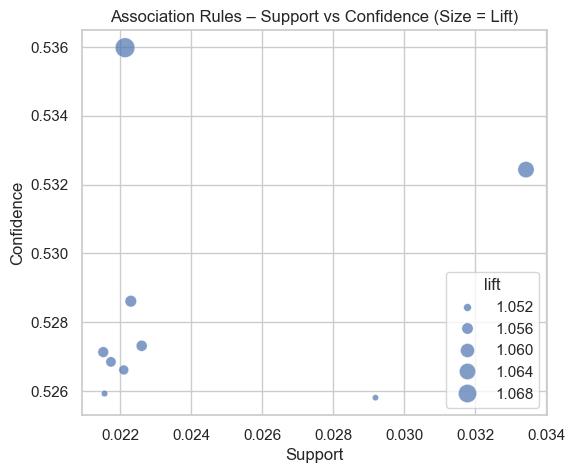

In [61]:
plot_df = strong_rules if not strong_rules.empty else rules

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=plot_df,
    x="support",
    y="confidence",
    size="lift",
    sizes=(20, 200),
    alpha=0.7
)
plt.title("Association Rules – Support vs Confidence (Size = Lift)")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.show()

### Real-World Meaning of These Patterns

The patterns found in this project can be useful in real healthcare settings in several ways.  
First, the classification models show how patient information can help identify who may need extra attention or follow-up care. This kind of early insight can support better health outcomes by helping providers act sooner rather than later.

The clustering results give a clearer picture of how different groups of patients tend to behave or what conditions they commonly share. Hospitals could use this information to better plan staff schedules, organize treatment areas, or prepare for groups of patients who may need more support.

The association rules highlight connections between diagnoses, medications, test results, and other patient details. These kinds of patterns can help doctors and administrators understand how certain conditions tend to appear together, which treatments are common, or where workflows might be improved.

Overall, these insights help in decision-making, improve day-to-day operations, and support better care for patients by helping healthcare teams understand their populations more clearly.

# Final Summary and Real-World Relevance

This project demonstrated how classification, clustering, and association rule mining can be applied to healthcare data to support operational and clinical decisions.

- **Classification** accurately predicted diabetes patients using demographic and medical attributes.
- **Clustering** revealed meaningful patient segments useful for resource planning.
- **Association Rules** identified relationships that can assist in medication planning, patient risk detection, and workflow optimization.

These findings illustrate how data mining techniques contribute to better patient outcomes and more efficient healthcare operations.